<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/%EC%83%88%EB%A1%9C%EC%9A%B4%20%EA%B0%80%EC%A0%95_0211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 새로운 가정
+ feature의 importance 는 p(y|x)의 관계이지, p(x)와는 독립적이다.
+ 맞다. 그러나, DNA철학(?) 즉, 미래(성장?)의 내용이 DNA에 들어 있듯이, 특정 기간의 p(y|x) 내부에는 이후의 p(y|x) 변화를 감지할 수 있는 정보가 들어있지 않을까?
+ 즉, 일정기간(범위)의 학습과정에서 내포된 importance의 변화를 반영한 학습을 할 수 있지 않겠는가?

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random
np.random.seed(1337)

In [4]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [6]:


from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
     
COLUMNS = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']     

## concept drift의 case #2

Concept(Rule)의 변화 : X<br>
Importance의 변화 : O<br>
Drift의 변화 : X<br>

In [7]:
import random

seed_everything(seed=49)

data_x = {}
weight = {}
errors = []
# 난수의 평균
means = [1,1,1,1,1,1,1,1,1,1]
# 난수의 표준편차
stds1 =  [1,1,1,1,1,1,1,1,1,1]
# feature의 가중치
wss1 =   [10,9,8,7,6,5,4,3,2,1]
wss2 =   [1,2,3,4,5,6,7,8,9,10]
# drift가 발생하는 feature
drift_feature = [1,1,-1,1,1,0,-1,1,0,1]
for f in range(10):
    data_x[f'x{f}'] = []
    weight[f'w{f}'] = []
    for i in range(100000):
        #for j in range(10):
        data_x[f'x{f}'].extend(np.random.normal(means[f],0.0001,10))  
        ww = i/100000
        weight[f'w{f}'].extend((wss1[f]*(1-ww) + wss2[f]*ww) + np.zeros((10))) # np.random.normal(0.0,0.0,10))                          

'''
for i in range(10000):        
    errors.extend(np.random.normal(0.0,0.005,10))
'''
dataset = pd.DataFrame(data_x)
importance = pd.DataFrame(weight)

y=np.sum(np.multiply(importance.values,dataset.values),axis=1) # + np.asarray(errors)

In [8]:
dataset

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.999896,1.000253,1.000089,1.000097,1.000051,1.000139,1.000027,1.000099,1.000014,1.000035
1,0.999918,1.000055,1.000017,0.999995,0.999948,1.000010,1.000009,0.999868,0.999995,0.999970
2,1.000067,0.999915,1.000103,1.000047,0.999958,0.999968,0.999939,0.999988,1.000121,1.000081
3,1.000182,1.000098,0.999947,0.999857,0.999862,1.000045,0.999952,0.999759,0.999917,1.000072
4,0.999856,0.999868,1.000098,0.999892,1.000137,0.999907,1.000057,1.000063,1.000064,0.999943
...,...,...,...,...,...,...,...,...,...,...
999995,0.999966,0.999813,0.999975,0.999932,1.000120,1.000036,1.000072,0.999900,1.000036,1.000149
999996,1.000070,1.000065,1.000099,0.999938,1.000076,1.000134,0.999954,1.000095,0.999836,0.999953
999997,1.000091,0.999902,1.000090,0.999987,0.999986,0.999950,1.000142,1.000129,1.000006,1.000041
999998,1.000071,0.999943,1.000180,1.000123,1.000038,0.999954,1.000154,0.999841,0.999987,1.000017


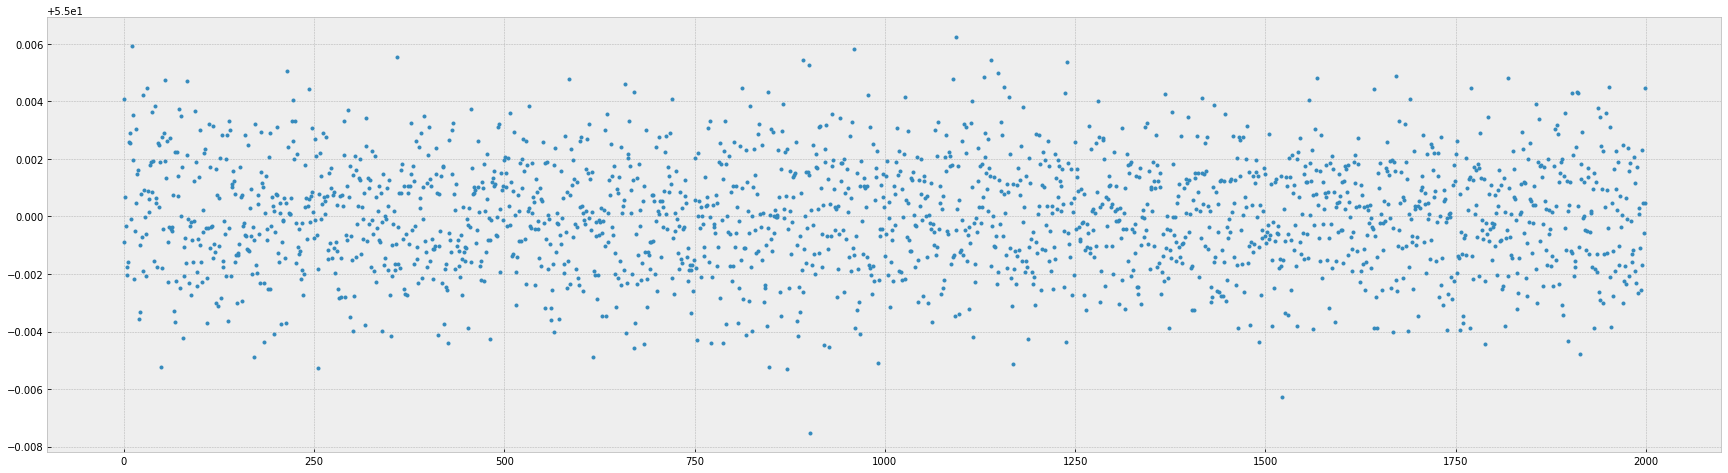

In [9]:
plt.figure(figsize=(30,8))
plt.plot(y[0:2000],'.')

In [10]:
mn = np.mean(y[0:15000])
print("Y mean:",mn)
dataset['y'] = [1 if i > mn else 0 for i in y]
dataset

Y mean: 54.999997218787435


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,0.999896,1.000253,1.000089,1.000097,1.000051,1.000139,1.000027,1.000099,1.000014,1.000035,1
1,0.999918,1.000055,1.000017,0.999995,0.999948,1.000010,1.000009,0.999868,0.999995,0.999970,0
2,1.000067,0.999915,1.000103,1.000047,0.999958,0.999968,0.999939,0.999988,1.000121,1.000081,1
3,1.000182,1.000098,0.999947,0.999857,0.999862,1.000045,0.999952,0.999759,0.999917,1.000072,0
4,0.999856,0.999868,1.000098,0.999892,1.000137,0.999907,1.000057,1.000063,1.000064,0.999943,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,0.999966,0.999813,0.999975,0.999932,1.000120,1.000036,1.000072,0.999900,1.000036,1.000149,1
999996,1.000070,1.000065,1.000099,0.999938,1.000076,1.000134,0.999954,1.000095,0.999836,0.999953,0
999997,1.000091,0.999902,1.000090,0.999987,0.999986,0.999950,1.000142,1.000129,1.000006,1.000041,1
999998,1.000071,0.999943,1.000180,1.000123,1.000038,0.999954,1.000154,0.999841,0.999987,1.000017,1


+ trainset에 index를 포함시킨다.
+ index는 시간의 경과에 해당되며, 이 index의 수치에 따라, p(y|x)에 대한 importance의 변화가 반영될 수 있지 않겠는가???

In [11]:
dataset['ix'] = dataset.index.values

In [12]:
dataset

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y,ix
0,0.999896,1.000253,1.000089,1.000097,1.000051,1.000139,1.000027,1.000099,1.000014,1.000035,1,0
1,0.999918,1.000055,1.000017,0.999995,0.999948,1.000010,1.000009,0.999868,0.999995,0.999970,0,1
2,1.000067,0.999915,1.000103,1.000047,0.999958,0.999968,0.999939,0.999988,1.000121,1.000081,1,2
3,1.000182,1.000098,0.999947,0.999857,0.999862,1.000045,0.999952,0.999759,0.999917,1.000072,0,3
4,0.999856,0.999868,1.000098,0.999892,1.000137,0.999907,1.000057,1.000063,1.000064,0.999943,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.999966,0.999813,0.999975,0.999932,1.000120,1.000036,1.000072,0.999900,1.000036,1.000149,1,999995
999996,1.000070,1.000065,1.000099,0.999938,1.000076,1.000134,0.999954,1.000095,0.999836,0.999953,0,999996
999997,1.000091,0.999902,1.000090,0.999987,0.999986,0.999950,1.000142,1.000129,1.000006,1.000041,1,999997
999998,1.000071,0.999943,1.000180,1.000123,1.000038,0.999954,1.000154,0.999841,0.999987,1.000017,1,999998


+ MI의 측정

In [13]:
mi_scores = make_mi_scores(dataset[0:10000][COLUMNS], dataset[0:10000]['y'], discrete_features="auto")
mi_scores

x0    0.090302
x1    0.064054
x2    0.050363
x3    0.040729
x5    0.031939
x4    0.024128
x6    0.015518
x7    0.002589
x8    0.000000
x9    0.000000
Name: MI Scores, dtype: float64

In [14]:
mi_scores = make_mi_scores(dataset[10000:20000][COLUMNS], dataset[10000:20000]['y'], discrete_features="auto")
mi_scores

x0    0.095924
x2    0.062375
x1    0.060145
x3    0.038909
x4    0.034857
x5    0.017828
x7    0.014328
x6    0.013027
x9    0.006244
x8    0.000000
Name: MI Scores, dtype: float64

+ Random-forest로 학습한다.
+ ix (시간의 경과)에 따른 importance가 내포 될 수 있을까?
+ 구조적으로 안될 것 같은데....

In [15]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

trainset = dataset[0:15000].drop(columns=['y']).values
train_y = dataset[0:15000]['y'].values

business_model = RandomForestClassifier(n_estimators=80,max_depth=5)
business_model.fit(trainset,train_y)

testset = dataset[15000:20000].drop(columns=['y']).values
test_y = dataset[15000:20000]['y'].values
base_score = precision_recall_fscore_support(test_y, business_model.predict(testset),average='binary')
base_score

(0.8547271329746349, 0.8728414442700158, 0.8636893203883497, None)

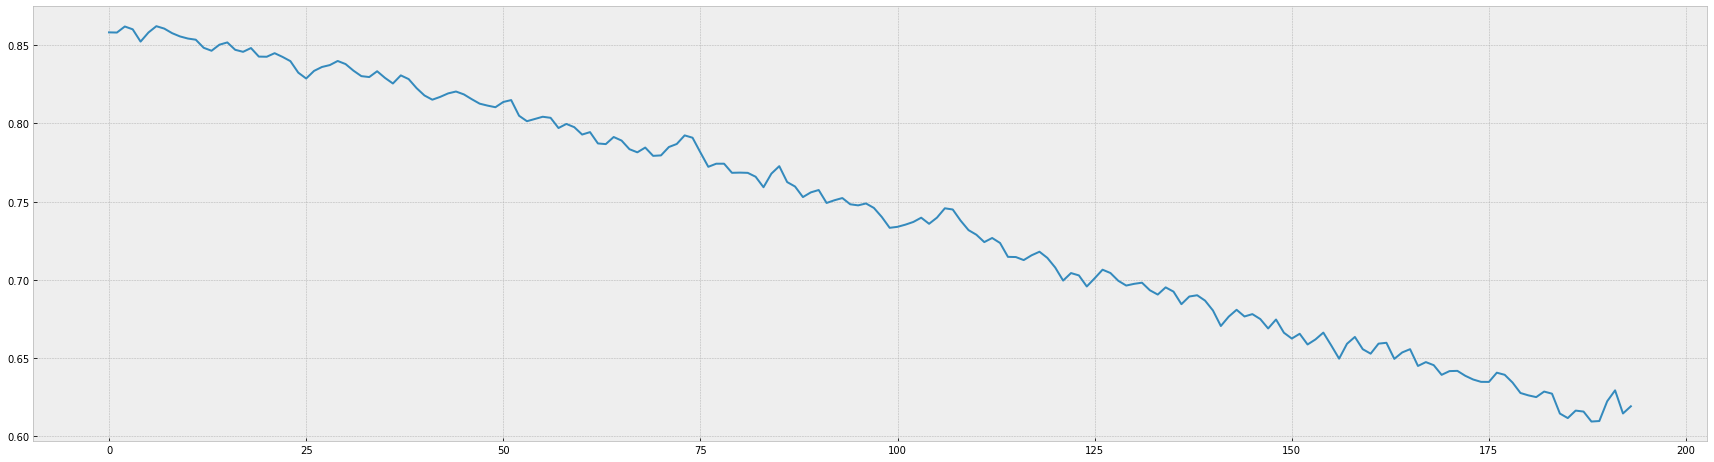

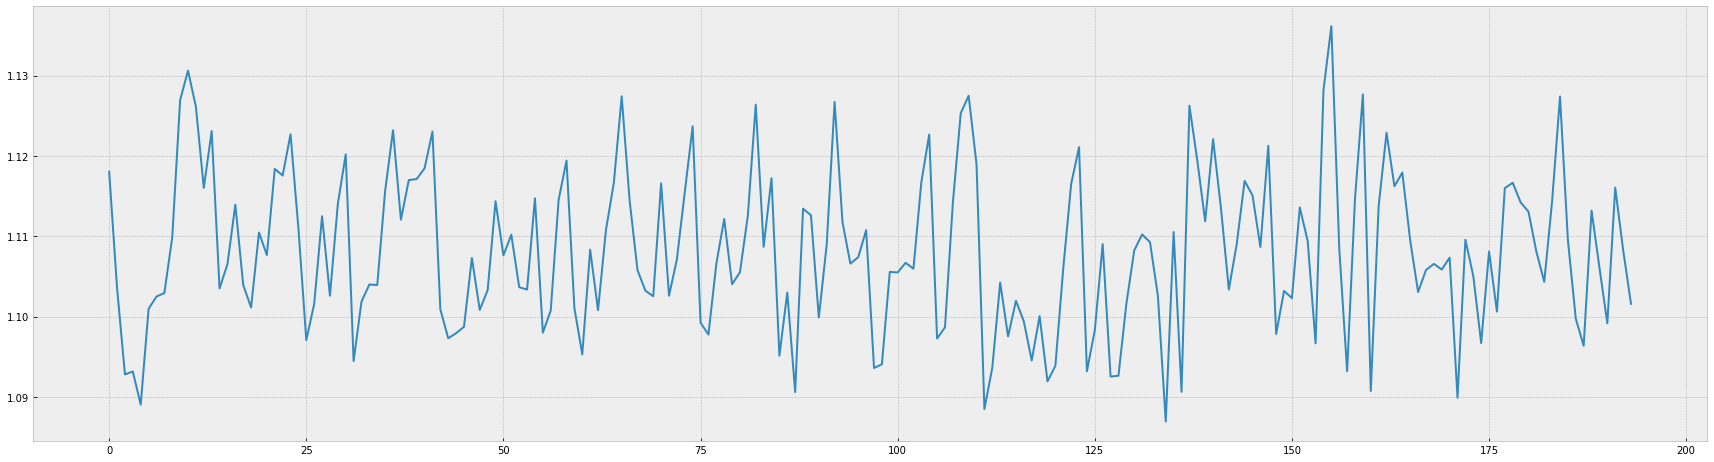

In [792]:
import math

X2 = dataset[20000:].drop(columns=['y']).values
Y2 = dataset[20000:]['y'].values

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
window_size = 10000
step = 5000
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset,ux)
    result['precision'].append(f1[2])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

result_df = pd.DataFrame(result)
result_df['precision'].plot(figsize=(30,8))
plt.show()
result_df['drift'].plot(figsize=(30,8))
plt.show()
     

In [ ]:
np.zeros((1,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [794]:
import math
from scipy.special import rel_entr

result = {}
result['precision'] = []
#result['sub_precision'] = []
#result['y_-y__'] = []
result['drift'] = []

drifts = {}
for f in range(10):
    drifts[f'x{f}'] = []

#MI
mi_scores = make_mi_scores(pd.DataFrame(trainset[:,0:10],columns=COLUMNS), train_y, discrete_features="auto")
print(mi_scores.values.reshape(1,-1))
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
imp_df_mi2 = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
#imp_df_mi3 = pd.DataFrame(np.zeros((1,10)),columns=list(mi_scores.keys()))[COLUMNS]
window_size = 10000
step = 5000
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    y_ = business_model.predict(ux)
    #y__ = sub_business_model.predict(ux[500:])
    f1 = precision_recall_fscore_support(uy,y_ ,average='binary')
    #f1_ = precision_recall_fscore_support(uy[0:500],y__ ,average='binary')
    drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    #result['sub_precision'].append(f1_[0])
    ## KL divergence 
    #result['y_-y__'].append(np.std(y_) - np.std(y__))
    result['drift'].append(sum(abs(drift[:,0])))
    for idx, dv in enumerate(drift[:,0]):
        if idx < 10:
            drifts[f'x{idx}'].append(dv)    
            
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), uy, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    #PMI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), y_, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi2.loc[len(imp_df_mi2)] = tmp_df.values.reshape(-1,)

    
    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


[[0.08819734 0.0693969  0.0474005  0.04449023 0.02977102 0.02822992
  0.01163105 0.00688073 0.0026119  0.        ]]
194/194 f1:0.6192

[]

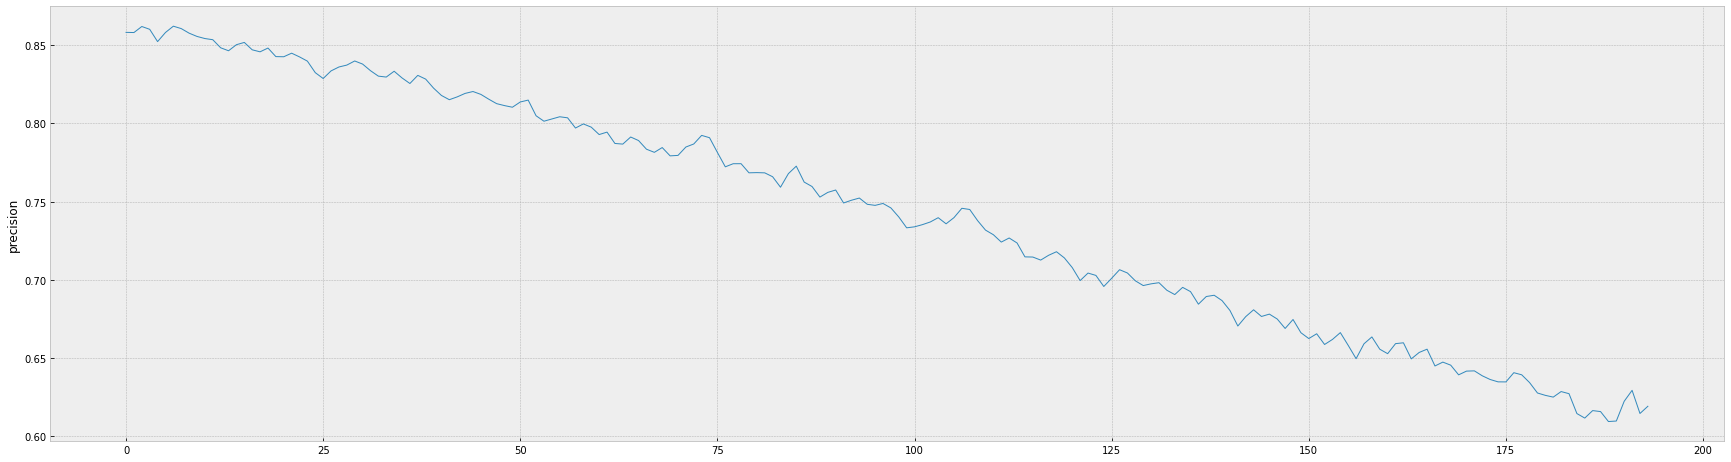

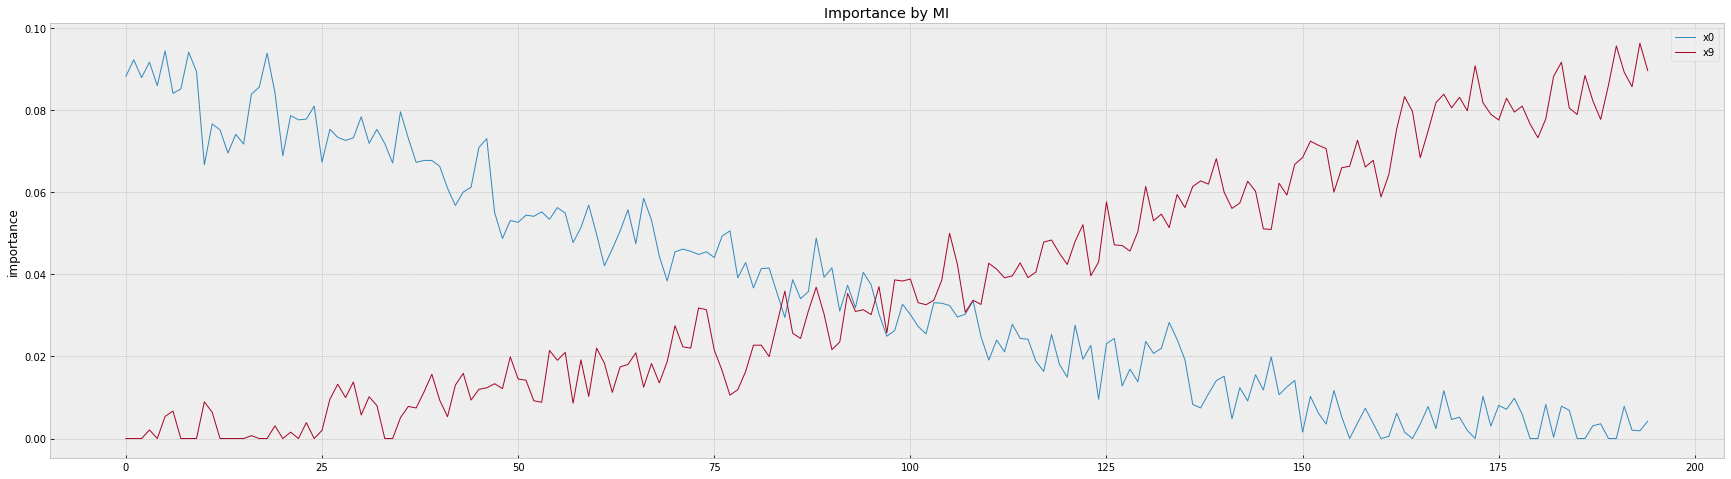

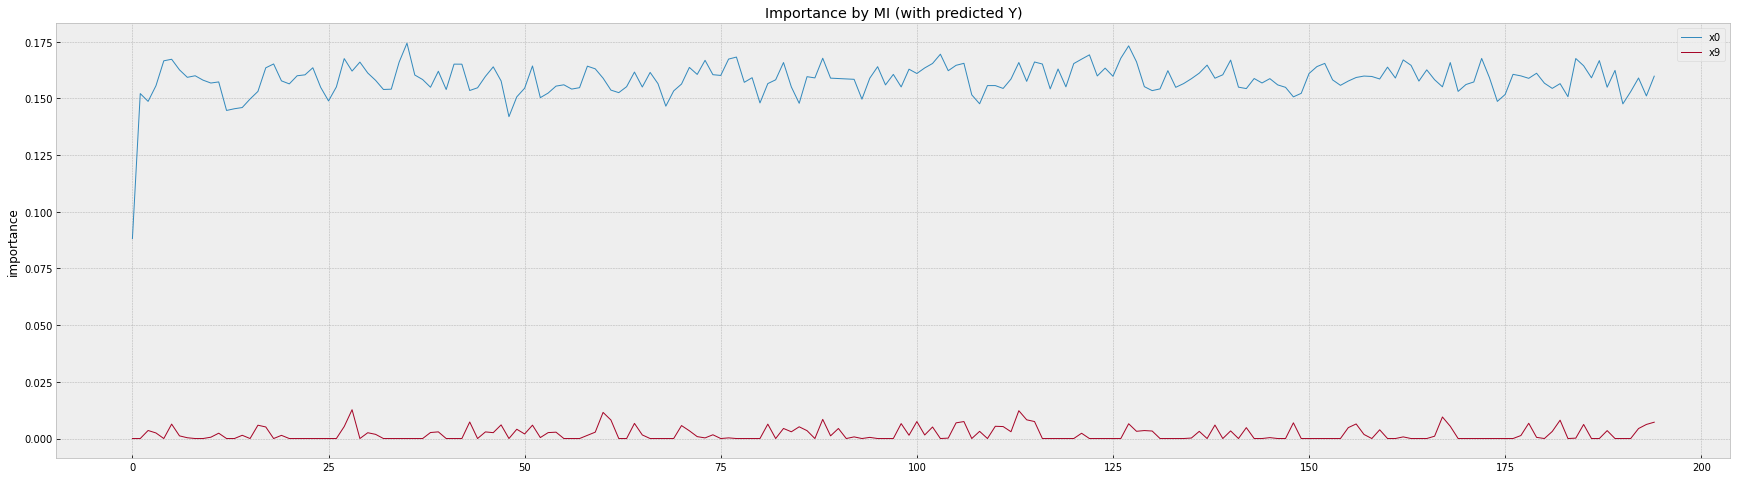

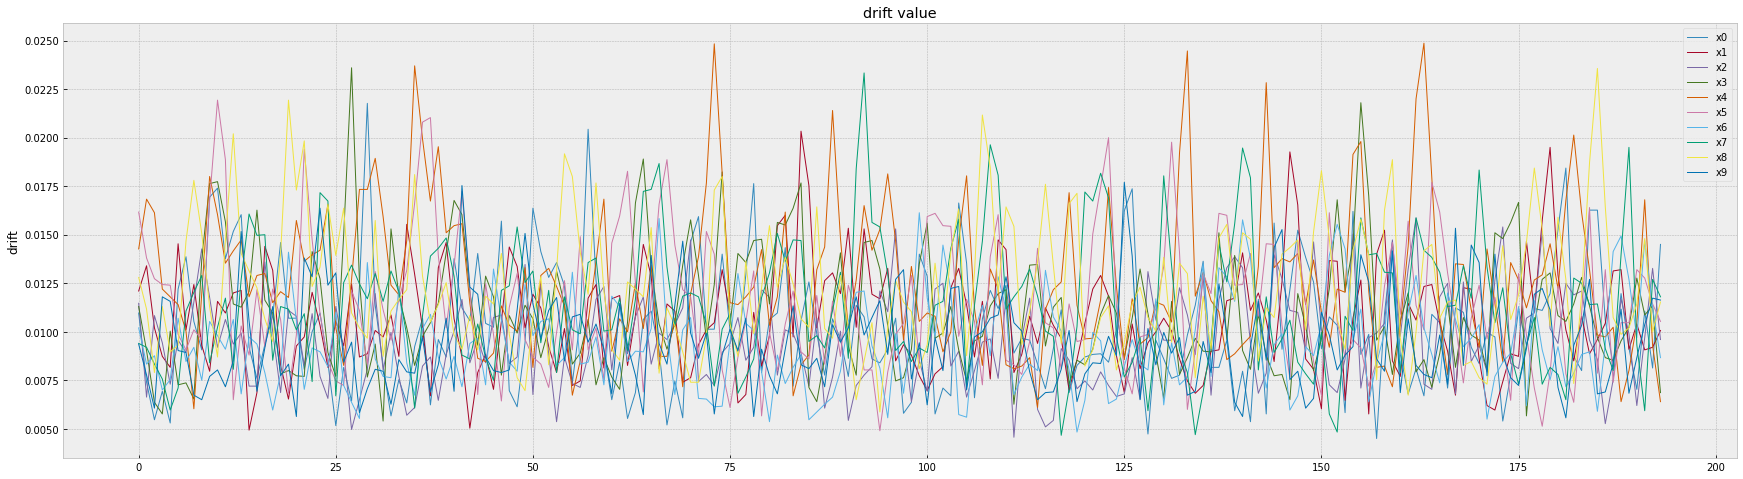

In [795]:
plt.style.use('bmh')

result_df = pd.DataFrame(result)
#result_df[['precision','sub_precision']].plot(ylabel='precision',linewidth=1,figsize=(30,8))
result_df['precision'].plot(ylabel='precision',linewidth=1,figsize=(30,8))

#result_df[['y_-y__']].plot(ylabel='delta Y',linewidth=1,figsize=(30,8))


ax = imp_df_mi[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

ax = imp_df_mi2[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

'''
ax = imp_df_mi3.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y from sub model)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
'''

tmp_df = pd.DataFrame(drifts)

ax = tmp_df.plot(ylabel='drift',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("drift value",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

### 결론

역시, ix의 변화에 따른 importance의 변화는 학습되지 못 했다.

### Deep architecture에 의한 importance의 변화 반영 여부 실험!

In [16]:

def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])
     

In [17]:
trainset = dataset[0:15000].drop(columns=['y']).values[:,0:10]
train_y = dataset[0:15000]['y'].values

In [18]:
import os.path 

scaler = MinMaxScaler()
x_train = scaler.fit_transform(trainset)
y_train = get_one_hot(train_y ,2)

# building the model
model = Sequential()
model.add(Dense(units=40,activation='relu'))
model.add(Dense(units=20,activation='relu'))
model.add(Dense(units=2,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model)
model.fit(x=x_train, 
        y=y_train, 
        epochs=100,
        batch_size=1000,
        verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 3ms/step - loss: 0.6936 - accuracy: 0.5032
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5091
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5110
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6738 - accuracy: 0.5892
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.6105
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6554 - accuracy: 0.6729
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6829
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.7176
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5983 - accuracy: 0.7338
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5723 - accuracy: 0.7431
Epoch 11/

In [19]:
testset = dataset[15000:20000].drop(columns=['y']).values[:,0:10]
test_y = dataset[15000:20000]['y'].values

In [20]:

Y3_ = model.predict(scaler.transform(testset),verbose=0)
Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])

base_score = precision_recall_fscore_support(test_y, Y4_,average='binary')
base_score

(0.9914230019493178, 0.9980376766091051, 0.9947193428515547, None)

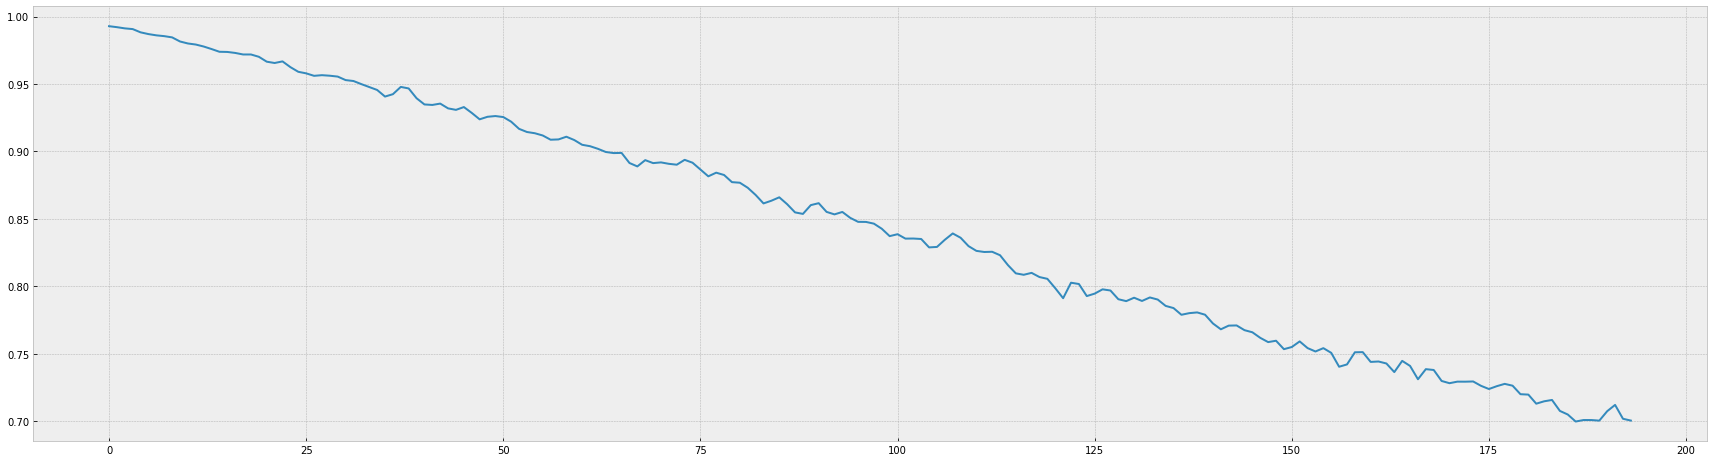

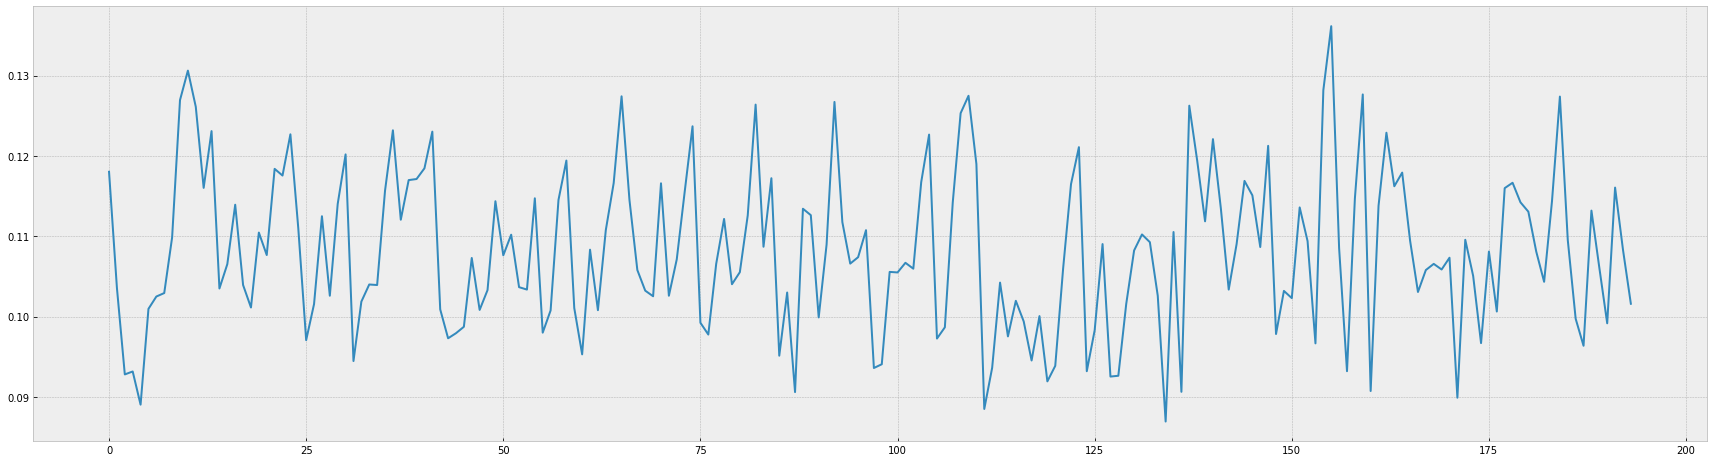

In [22]:
import math 

X2 = dataset[20000:].drop(columns=['y']).values
Y2 = dataset[20000:]['y'].values

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
window_size = 10000
step = 5000
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size][:,0:10]
    uy = Y2[i*step:i*step+window_size]

    Y3_ = model.predict(scaler.transform(ux),verbose=0)
    Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])

    f1 = precision_recall_fscore_support(uy, Y4_,average='binary')

    #f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

result_df = pd.DataFrame(result)
result_df['precision'].plot(figsize=(30,8))
plt.show()
result_df['drift'].plot(figsize=(30,8))
plt.show()

+ ix 적용 비교...

In [53]:
# 클수로... 시간요소가 작아진다.
gamma = 1000000000

### ix 적용 실험

In [54]:
trainset = dataset[0:15000].drop(columns=['y']).values
train_y = dataset[0:15000]['y'].values

In [55]:
trainset

array([[9.99895684e-01, 1.00025307e+00, 1.00008881e+00, ...,
        1.00001418e+00, 1.00003539e+00, 0.00000000e+00],
       [9.99917914e-01, 1.00005489e+00, 1.00001682e+00, ...,
        9.99995325e-01, 9.99969567e-01, 1.00000000e+00],
       [1.00006651e+00, 9.99915149e-01, 1.00010341e+00, ...,
        1.00012092e+00, 1.00008110e+00, 2.00000000e+00],
       ...,
       [1.00010101e+00, 1.00002887e+00, 1.00009398e+00, ...,
        9.99909963e-01, 1.00002712e+00, 1.49970000e+04],
       [1.00001580e+00, 1.00002502e+00, 1.00006750e+00, ...,
        1.00000317e+00, 1.00004429e+00, 1.49980000e+04],
       [1.00008865e+00, 9.99870717e-01, 1.00005034e+00, ...,
        9.99900989e-01, 9.99942591e-01, 1.49990000e+04]])

In [56]:
trainset[:,10] = trainset[:,10]/gamma

In [57]:
trainset

array([[9.99895684e-01, 1.00025307e+00, 1.00008881e+00, ...,
        1.00001418e+00, 1.00003539e+00, 0.00000000e+00],
       [9.99917914e-01, 1.00005489e+00, 1.00001682e+00, ...,
        9.99995325e-01, 9.99969567e-01, 1.00000000e-09],
       [1.00006651e+00, 9.99915149e-01, 1.00010341e+00, ...,
        1.00012092e+00, 1.00008110e+00, 2.00000000e-09],
       ...,
       [1.00010101e+00, 1.00002887e+00, 1.00009398e+00, ...,
        9.99909963e-01, 1.00002712e+00, 1.49970000e-05],
       [1.00001580e+00, 1.00002502e+00, 1.00006750e+00, ...,
        1.00000317e+00, 1.00004429e+00, 1.49980000e-05],
       [1.00008865e+00, 9.99870717e-01, 1.00005034e+00, ...,
        9.99900989e-01, 9.99942591e-01, 1.49990000e-05]])

In [58]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(trainset)
x_train[:,10] = trainset[:,10]
y_train = get_one_hot(train_y ,2)

# building the model
model = Sequential()
model.add(Dense(units=44,activation='relu'))
model.add(Dense(units=20,activation='relu'))
model.add(Dense(units=2,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model)
model.fit(x=x_train, 
        y=y_train, 
        epochs=100,
        batch_size=1000,
        verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.6918 - accuracy: 0.5028
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5043
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5235
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6706 - accuracy: 0.5825
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6262
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.6833
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.7096
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.7221
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5842 - accuracy: 0.7392
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5604 - accuracy: 0.7439
Epoch 11/

In [59]:
testset = dataset[15000:20000].drop(columns=['y']).values

In [60]:
testset

array([[9.99958163e-01, 1.00018446e+00, 9.99982194e-01, ...,
        9.99864670e-01, 1.00006324e+00, 1.50000000e+04],
       [1.00005358e+00, 1.00001132e+00, 1.00005706e+00, ...,
        9.99986815e-01, 9.99763922e-01, 1.50010000e+04],
       [1.00001069e+00, 1.00005439e+00, 9.99990620e-01, ...,
        1.00001428e+00, 1.00005029e+00, 1.50020000e+04],
       ...,
       [9.99998942e-01, 9.99945455e-01, 1.00006506e+00, ...,
        1.00007004e+00, 9.99940046e-01, 1.99970000e+04],
       [9.99987698e-01, 1.00001177e+00, 9.99907162e-01, ...,
        9.99833199e-01, 1.00000583e+00, 1.99980000e+04],
       [1.00001244e+00, 1.00000398e+00, 9.99986048e-01, ...,
        9.99941699e-01, 1.00005541e+00, 1.99990000e+04]])

In [61]:
testset[:,10] = testset[:,10]/gamma
test_y = dataset[15000:20000]['y'].values

In [62]:
test_x = scaler.transform(testset)
test_x[:,10] = testset[:,10]

In [63]:
Y3_ = model.predict(test_x,verbose=0)
Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])

base_score = precision_recall_fscore_support(test_y, Y4_,average='binary')
base_score

(0.9795996920708238, 0.9988226059654631, 0.9891177613680529, None)

In [64]:

X2 = dataset[20000:].drop(columns=['y']).values
X2[:,10] = X2[:,10]/gamma
Y2 = dataset[20000:]['y'].values

In [65]:
X2

array([[1.00010031e+00, 9.99906904e-01, 1.00012732e+00, ...,
        1.00003046e+00, 1.00014347e+00, 2.00000000e-05],
       [9.99937927e-01, 9.99839756e-01, 9.99986302e-01, ...,
        1.00001218e+00, 1.00008618e+00, 2.00010000e-05],
       [1.00004901e+00, 9.99879273e-01, 1.00005212e+00, ...,
        9.99872678e-01, 9.99869043e-01, 2.00020000e-05],
       ...,
       [1.00009107e+00, 9.99902439e-01, 1.00008951e+00, ...,
        1.00000591e+00, 1.00004106e+00, 9.99997000e-04],
       [1.00007051e+00, 9.99942576e-01, 1.00017988e+00, ...,
        9.99987173e-01, 1.00001727e+00, 9.99998000e-04],
       [9.99939003e-01, 9.99994127e-01, 9.99978441e-01, ...,
        9.99925880e-01, 9.99985960e-01, 9.99999000e-04]])

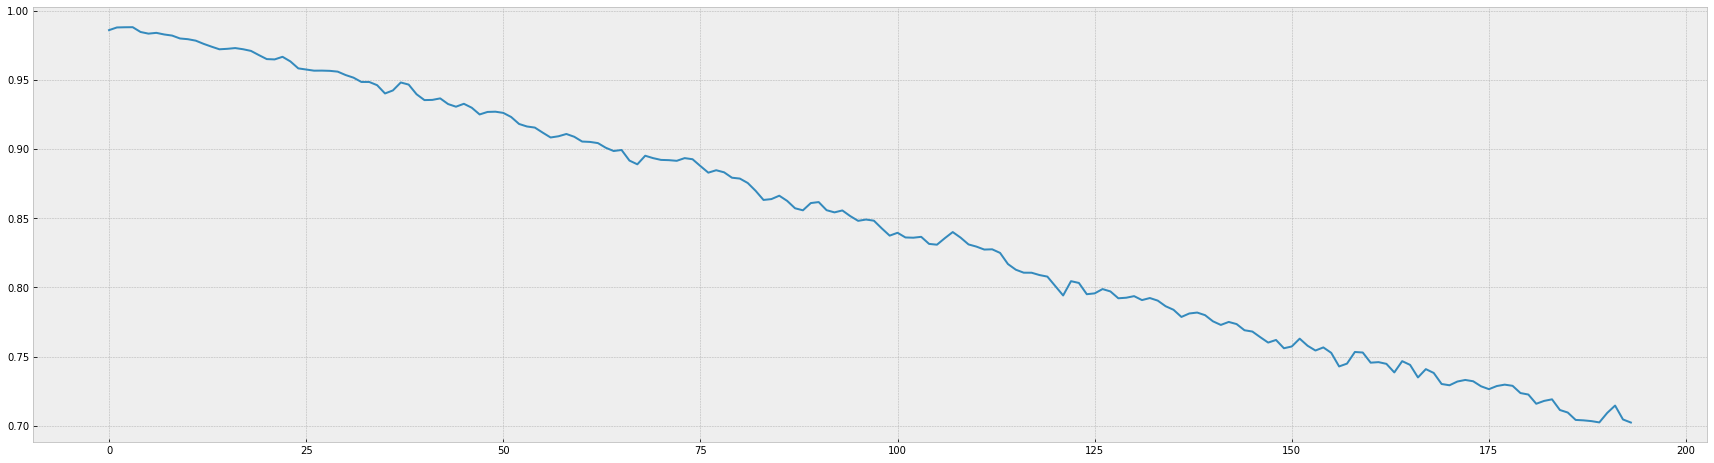

In [66]:

result = {}
result['precision'] = []
result['predicted'] = []
#result['drift'] = []
window_size = 10000
step = 5000
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    ux_ = scaler.transform(ux)
    ux_[:,10] = ux[:,10]
    Y3_ = model.predict(ux_,verbose=0)
    Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])

    f1 = precision_recall_fscore_support(uy, Y4_,average='binary')

    #f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    #drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    result['predicted'].append(0.0)
    #result['drift'].append(sum(abs(drift[:,0])))

result_df = pd.DataFrame(result)
result_df['precision'].plot(figsize=(30,8))
plt.show()


### 다음 step

In [745]:
import math
from scipy.special import rel_entr

result = {}
result['precision'] = []
#result['sub_precision'] = []
#result['y_-y__'] = []
result['drift'] = []

drifts = {}
for f in range(10):
    drifts[f'x{f}'] = []

#MI
mi_scores = make_mi_scores(pd.DataFrame(trainset[:,0:10],columns=COLUMNS), train_y, discrete_features="auto")
print(mi_scores.values.reshape(1,-1))
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
imp_df_mi2 = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
#imp_df_mi3 = pd.DataFrame(np.zeros((1,10)),columns=list(mi_scores.keys()))[COLUMNS]
window_size = 1000
step = 500
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    ux_ = scaler.transform(ux)
    ux_[:,10] = ux[:,10]    
    Y3_ = model.predict(ux_,verbose=0)
    Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])
    #y__ = sub_business_model.predict(ux[500:])
    f1 = precision_recall_fscore_support(uy,Y4_ ,average='binary')
    #f1_ = precision_recall_fscore_support(uy[0:500],y__ ,average='binary')
    #drift = __ks_drift(trainset,ux)
    drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    #result['sub_precision'].append(f1_[0])
    ## KL divergence 
    #result['y_-y__'].append(np.std(y_) - np.std(y__))
    result['drift'].append(sum(abs(drift[:,0])))
    for idx, dv in enumerate(drift[:,0]):
        drifts[f'x{idx}'].append(dv)    
            
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), uy, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    #PMI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), Y4_, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi2.loc[len(imp_df_mi2)] = tmp_df.values.reshape(-1,)

    
    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


[[0.09141603 0.0909163  0.08469528 0.03749834 0.035839   0.02363077
  0.02011068 0.01872192 0.01768245 0.01684535]]
72/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


73/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


74/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


75/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


78/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


79/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


80/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


81/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


85/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


86/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


87/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


88/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


89/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


90/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


91/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


93/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


94/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


96/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


99/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


101/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


102/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


103/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


104/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


105/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


106/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


107/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


108/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


109/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


110/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


111/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


112/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


113/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


114/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


116/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


117/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


118/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


119/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


122/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


123/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


124/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


125/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


126/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


127/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


128/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


130/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


131/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


132/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


133/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


134/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


135/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


136/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


137/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


138/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


139/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


140/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


142/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


143/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


144/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


146/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


147/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


148/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


149/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


150/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


151/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


152/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


153/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


154/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


155/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


156/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


157/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


158/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


159/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


161/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


162/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


163/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


165/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


166/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


167/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


168/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


169/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


170/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


171/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


172/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


173/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


174/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


175/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


176/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


177/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


178/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


179/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


180/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


181/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


182/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


183/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


184/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


185/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


186/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


187/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


188/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


189/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


191/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


192/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


193/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


194/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [746]:
len(drifts['x9'])

194

[]

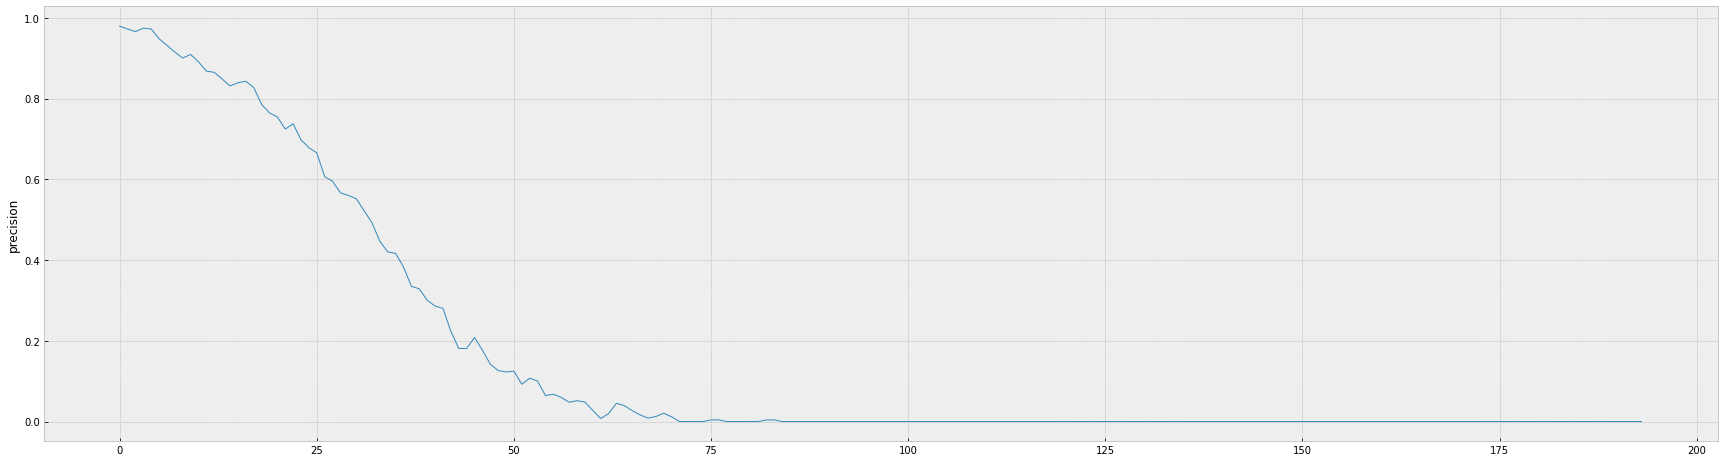

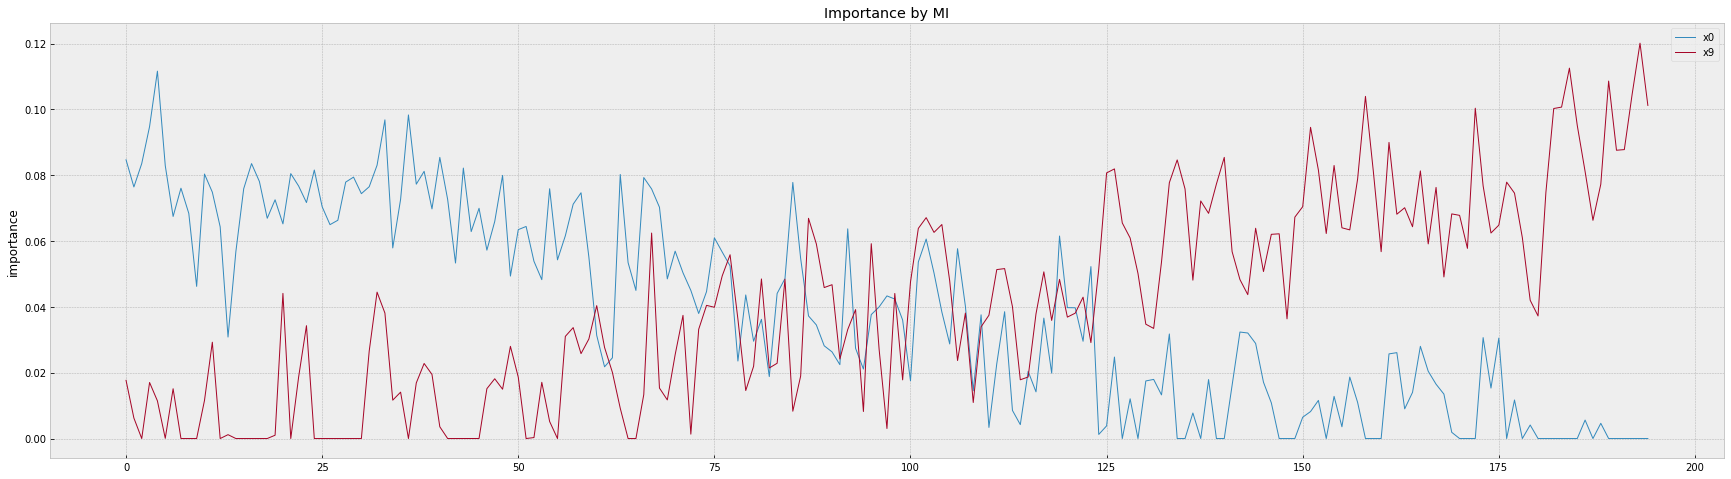

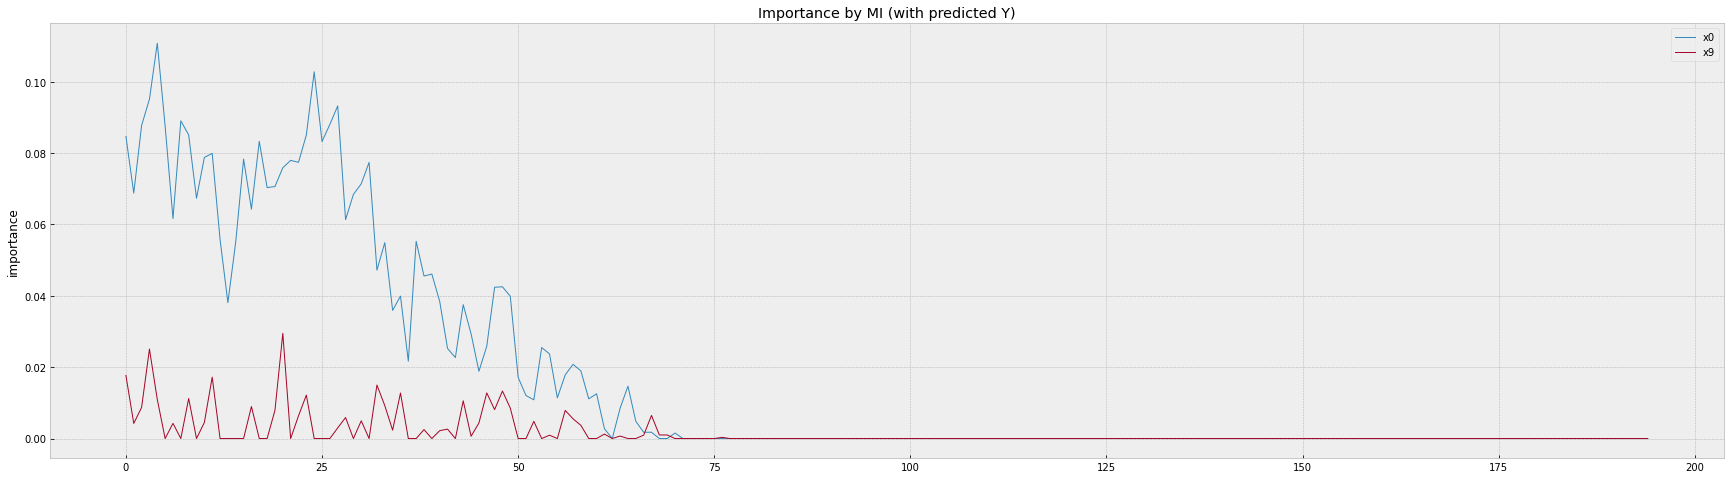

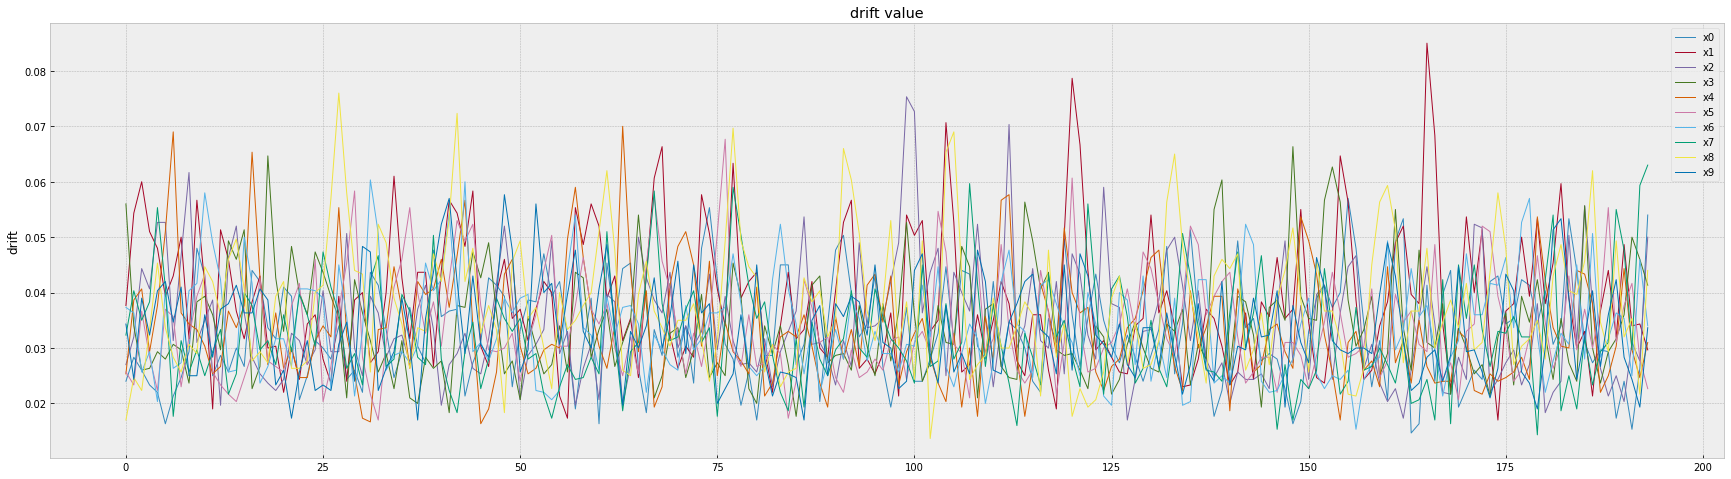

In [747]:
plt.style.use('bmh')

result_df = pd.DataFrame(result)
#result_df[['precision','sub_precision']].plot(ylabel='precision',linewidth=1,figsize=(30,8))
result_df['precision'].plot(ylabel='precision',linewidth=1,figsize=(30,8))

#result_df[['y_-y__']].plot(ylabel='delta Y',linewidth=1,figsize=(30,8))


ax = imp_df_mi[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

ax = imp_df_mi2[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
#ax = imp_df_mi2.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

'''
ax = imp_df_mi3.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y from sub model)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
'''

tmp_df = pd.DataFrame(drifts)

ax = tmp_df.plot(ylabel='drift',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("drift value",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

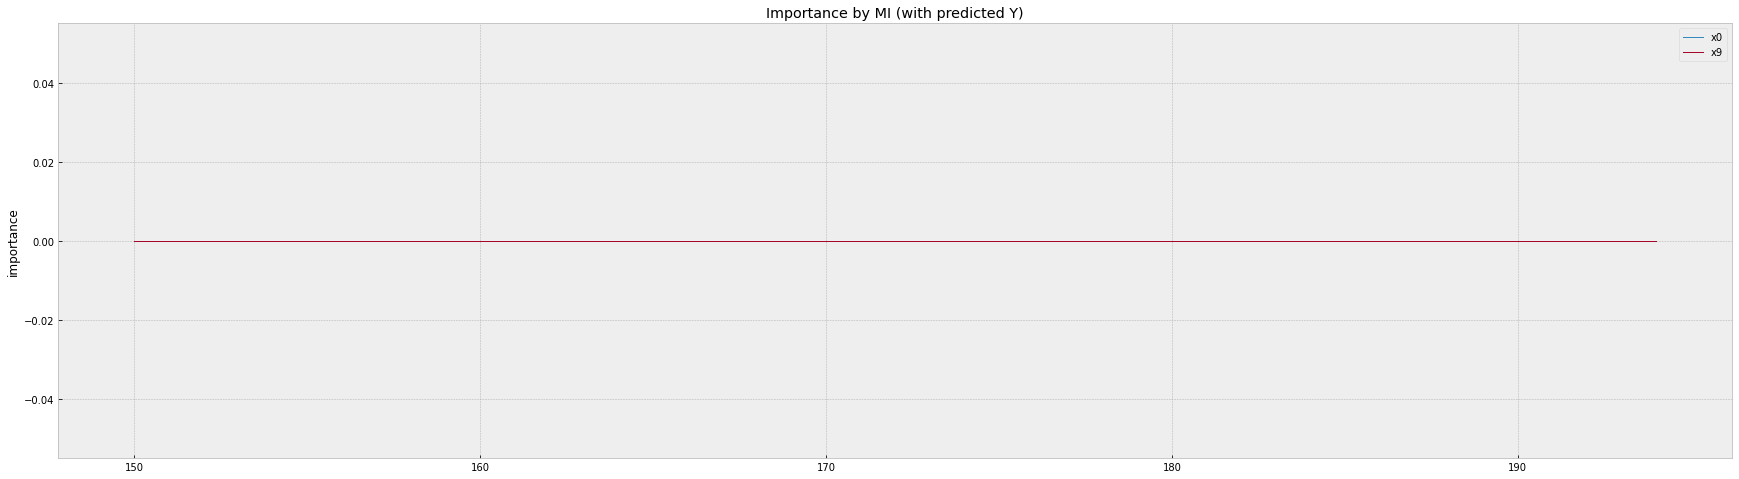

In [748]:
ax = imp_df_mi2[['x0','x9']][150:200].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()